# Double Pendulum
Our goal is to solve the double pendulum probem using numerical methods available to us in python

We choose our origin to be at the initial pivot of the first pendulum if we then coridinitize this situation we find they are given by


$x_1=l_2 \sin{\phi_1}$  $\space$           $y_1=-l_1\cos{\phi_1}$

$x_2=x_1+l_2 \sin{\phi_2}$  $\space$       $y_2= y_1-l_2 \cos{\phi_2}$

From here we apply the Lagrange method so first our Lagrangian is given by

$\mathscr{L}= 1/2 m_1 l_1^2 \dot{\phi_1}^2+1/2 m_2(l_1^2\dot{\phi_1}^2+2l_1 l_2 \dot{\phi_1}\dot{\phi_2}\cos{\phi_1-\phi_2}+l_2^2 \dot{\phi_2}^2) +2m_1 g \cos\phi_1 +m_2 g \cos{\phi_2}$

Using lagrange's equations we then obtain 

$-2 g l_1 m1 \sin \phi_1 -l_1 l_2 m_2 \dot \phi_1 \dot \phi_2 \sin{(\phi_1-\phi_2)}=m_1 l_1^2\ddot{\phi_1}+(1/2) m_2 (-2 l_1 l_2 \dot \phi_2 \sin{(\phi_1-\phi_2)} (\dot \phi_1-\dot{\phi_2}) +2 l_1 l_2 \ddot{\phi_2} \cos{(\phi_1-\phi_2)}+2 l_1^2 \ddot{\phi_1}$

$-m_2 l_2 g \sin{\phi_2}+l_1 l_2 m_2 \dot \phi_1 \dot \phi_2 \sin{(\phi_1-\phi_2)}= m_2 ( l_1 l_2 \dot \phi_1 \sin{(\phi_1-\phi_2)}( \dot \phi_1-\dot \phi_2)+ l_1 l_2 \ddot \phi_1 \cos{(\phi_1-\phi_2)}+ l_2^2 \ddot \phi$

For python to be able to solve this we must create a vector and then isolate the $\ddot{\phi_i}$'s and the equations are listed below


$\begin{align*}
\ddot \phi_1 &= \frac{-4 m_1 g \sin \phi_1+ g m_2 \sin \phi_1 - m_2 g \sin{(\phi_1- 2 \phi_2)}-l_1 m_2 \dot \phi_1^2 \sin{(2 \phi_1- 2 \phi_2)}-2 l_2 m_2 \dot \phi_2^2 \sin{(\phi_1-\phi_2)}}{l_1(2 m_1 +m2 -m2 \cos{(2\phi_1-2\phi_2)})}
\\
    \ddot \phi_2 &= \frac{2 g m_1 \sin{(2 \phi_1-  \phi_2)}- 2 g m_2 \sin \phi_2 +2 l_1 m_1 \dot \phi_1^2 \sin{( \phi_1-  \phi_2)} + 2 l_1 m_2 \dot \phi_1^2 \sin{( \phi_1-  \phi_2)} + l_2 m_2 \dot \phi_2^2 \sin{( 2\phi_1-  2\phi_2)} }{l_2(2 m_1+m_2-m_2 \sin{( 2\phi_1-  2\phi_2)}}
\end{align*}$


In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt
#import modules that are used to solve our equations of motion

In [2]:
#Define a class to do all the heavy lifting for solving the equations
class LagrangianDoublePendulum():
    """
    Pendulum class implements the parameters and Lagrange's equations for 
     a simple pendulum (no driving or damping).
     
    Parameters
    ----------
    L_1 : float
        length of the first simple pendulum
    L_2 : float
        length of the second simple pendulum
    g : float
        gravitational acceleration at the earth's surface

    m_1 : float
        mass of first pendulum
    m_2 : float
        mass of the second pendulum

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1.,L2=1., m1=1.,m2=1., g=1.
                ):
        self.L1 = L1
        self.L2=L2
        self.g = g
    
        self.m1 = m1
        self.m2 = m2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi0(t) and y[1] = dphi0/dt y[2]=phi1(t) 
            
        Returns
        -------
        
        """
        M=self.m1+self.m2
        C=np.cos(y[0]-y[2])
        dS=np.sin(y[0]-y[2])
        S1=np.sin(y[0])
        S2=np.sin(y[2])
        l1=self.L1
        l2=self.L2
        return [y[1],\
                (-4 * self.m1* self.g * S1 + self.g * self.m2 * S1\
                -self.m2 * self.g* np.sin(y[0]-2*y[2]) - l1 * self.m2 * y[1]**2 * np.sin(2* y[0]-2*y[2])\
                -2* l2 * self.m2 * y[3]**2 * dS)/(l1 *(2 *self.m1 + self.m2- self.m2* np.cos(2*y[0]-2*y[2]))),\
               y[3],\
               (2 * self.g *self.m1 *np.sin(2*y[0]-y[2]))- 2* self.g* self.m2 * S2\
               +2* l1* self.m1 * y[1]**2 * dS +2 *l1 *self.m2 * y[1]**2 * dS\
               +l2* self.m2* y[3]**2 * np.sin(2* y[0]-2* y[2])/(l2*(2* self.m1+ self.m2- self.m2* np.cos(2* y[0]- 2* y[2])))]
    
    def solve_ode(self, t_pts, phi_0, phi_dot_0, phi_1, phi_dot_1, 
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_0, phi_dot_0, phi_1, phi_dot_1] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi_0, phi_dot_0,phi_1, phi_dot_1 = solution.y

        return   phi_0, phi_dot_0,phi_1, phi_dot_1

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [5]:


# Creating a plotting time
t_start = 0.
t_end = 350.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 =1.
g = 1.
m1 = 1.
m2=1.

# Intialize a pendulum 
p1 = LagrangianDoublePendulum(L1=L1, L2=L2, m1=m1,m2=m2, g=g)


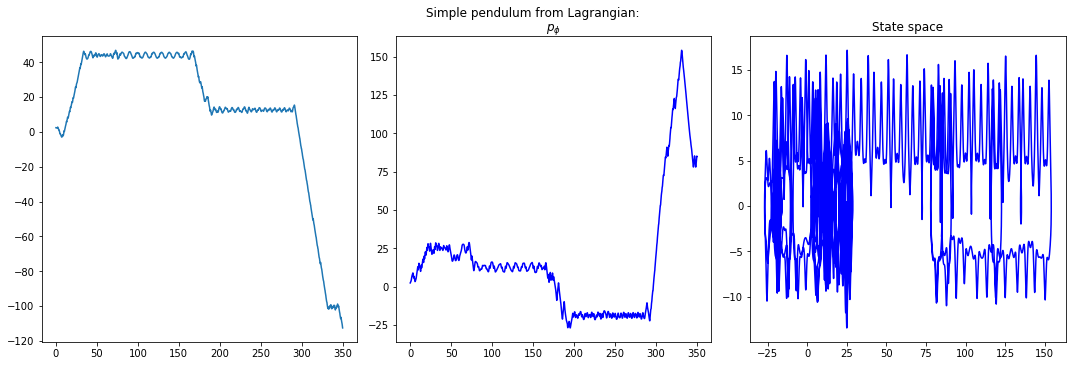

In [6]:
# solve the double pendulum with set initial conditions
phi_0 = (3./4.)*np.pi
phi_dot_0 = 0.
phi_1 = (3./4.)*np.pi
phi_dot_1 = 1.
phi_0, phi_dot_0, phi_1, phi_dot_1 = p1.solve_ode(t_pts, phi_0, phi_dot_0, phi_1, phi_dot_1)




We now look at $\phi_1$ and $\phi_2$ and how they change in time as well as the the state space of both masses

C:\Users\stark\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


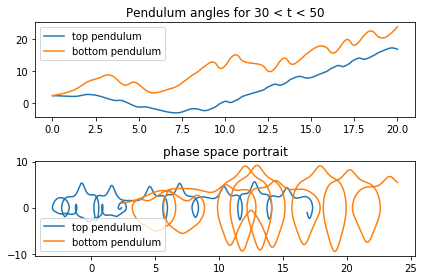

In [17]:
start, stop = start_stop_indices(t_pts, 0, 20)


fig = plt.figure()

ax1 = fig.add_subplot(2,1,1)
ax1.plot(t_pts[start:stop], phi_0[start:stop], label=('phi_1'))
ax1.plot(t_pts[start:stop], phi_1[start:stop], label = ('phi_2'))
ax1.legend()
ax1.set_title('Pendulum angles for 0 < t < 20')

ax2 = fig.add_subplot(2,1,2)
ax2.plot(phi_0[start:stop], phi_dot_0[start:stop],  label=('phi_1'))
ax2.plot(phi_1[start:stop], phi_dot_1[start:stop], label = ('phi_2'))
ax2.legend()
ax2.set_title('phase space portrait')

fig.tight_layout()
fig.show()

Here we see the two masses angles plotted as a function of time. We note that this is cyclic up to $2\pi$ so $0$ and $2\pi$ represent the same spatial point. Below we then show the motion from t=0 to t=50

C:\Users\stark\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


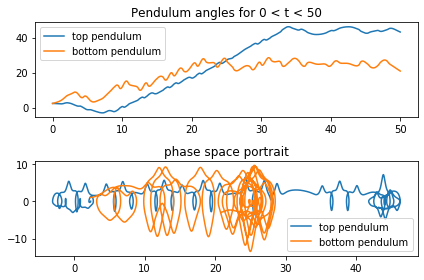

In [8]:
start, stop = start_stop_indices(t_pts, 0, 50)


fig = plt.figure()

ax1 = fig.add_subplot(2,1,1)
ax1.plot(t_pts[start:stop], phi_0[start:stop], label=('top pendulum'))
ax1.plot(t_pts[start:stop], phi_1[start:stop], label = ('bottom pendulum'))
ax1.legend()
ax1.set_title('Pendulum angles for 0 < t < 50')

ax2 = fig.add_subplot(2,1,2)
ax2.plot(phi_0[start:stop], phi_dot_0[start:stop],  label=('top pendulum'))
ax2.plot(phi_1[start:stop], phi_dot_1[start:stop], label = ('bottom pendulum'))
ax2.legend()
ax2.set_title('phase space portrait')

fig.tight_layout()
fig.show()

We are now interested in seeing if we can observe chaos. To do this we create different initial thats within $10^-7$ of the original. Then plot the difference bewtween the two solutions.

Text(0.5, 1.0, 'Pendulum angles for 0 < t < 50')

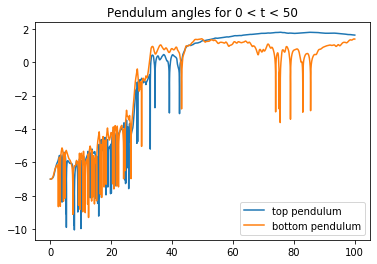

In [16]:
t_start = 0.
t_end = 350.
delta_t = 0.001
t_pts = np.arange(t_start, t_end+delta_t, delta_t) 
start, stop = start_stop_indices(t_pts, 0, 100)
phi_0d = (3./4.)*np.pi+.0000001
phi_dot_0d = 0.
phi_1d = (3./4.)*np.pi+.0000001
phi_dot_1d = 1.
phi_0d, phi_dot_0d, phi_1d, phi_dot_1d = p1.solve_ode(t_pts, phi_0d, phi_dot_0d, phi_1d, phi_dot_1d)

fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(t_pts[start:stop], np.log10(np.abs(phi_0[start:stop]-phi_0d[start:stop])), label=('top pendulum'))
ax1.plot(t_pts[start:stop], np.log10(np.abs(phi_1[start:stop]-phi_1d[start:stop])), label = ('bottom pendulum'))
ax1.legend()
ax1.set_title('Pendulum angles for 0 < t < 50')

We see initially that we are within $10^-7$ initally and then ends up at $10^2$. This is one indicator of chaos.